# 秘密情報管理サーバの利用

このNotebookではVCPが秘密情報管理のために提供している[HashiCorp Vault](https://www.vaultproject.io/)の利用手順について記しています。

> VCPのVaultサーバでは格納された秘密情報のバックアップや冗長管理は行っていないので、**元データの管理は利用者の責任**で行ってください。

## HashiCorp Vaultについて

[HashiCorp Vault](https://www.vaultproject.io/)は秘密情報を安全に管理するためのツールです。

### 特徴

HashiCorp Vault（以下ではVaultサーバと記します）には、以下のような特徴があります。

* セキュアな秘密保管
  - 任意のキー、バリューの組で秘密情報を格納できます。Vaultサーバではこれらの秘密情報を永続ストレージに書き込む前に暗号化しています。
* マスターキーの分割
  - 永続ストレージに記録している秘密情報はマスターキーによって暗号化されています。マスターキーは[シャミアの秘密分散法](https://en.wikipedia.org/wiki/Shamir%27s_Secret_Sharing)によって複数のキーに分割されています。閾値以上のキーを与えることで永続ストレージの情報は復号化できるようになります。
* 監査
  - Vaultサーバへの要求と応答は（エラーを含めて）その全てを監査ログに記録することができます。
* HTTP API
  - Vaultサーバのあらゆる機能は HTTP APIで操作できます。

### シークレットエンジン

Vaultサーバが秘密情報を扱うためのコンポーネントとしてシークレットエンジンがあります。シークレットエンジンには単なる Key Value ストアの機能をもつものから、動的に秘密情報を生成できるものまで様々なものが用意されています。

ここでは VCP で利用できる以下の２つのシークレットエンジンについて簡単にふれておきます。
1. [KV シークレットエンジン v1](https://www.vaultproject.io/docs/secrets/kv/kv-v1.html)
1. [Cubbyhole シークレットエンジン](https://www.vaultproject.io/docs/secrets/cubbyhole/index.html)

1.のKVシークレットエンジンはいわゆる Key Valueストア(KVS)です。通常のKVSと異なるのはValueに指定した値が暗号化されて保存されることです。

2.の Cubbyholeシークレットエンジンも1.と同様に暗号化をサポートしたKVSです。1.と異なるのはKVSのスコープがアクセストークン毎に別々になっていることです。つまりトークンAでアクセスした場合とトークンBでアクセスした場合で全く異なるKVSにアクセスするようになっています。それぞれのKVSはお互いにアクセスできないようになっています。

VCPではユーザ毎に別々のトークンを発行することになるので、VC Controllerに属する全てのユーザが共有する秘密情報はKVシークレットエンジンに、ユーザ個々が保持する秘密情報はCubbyholeシークレットエンジンに保管するという利用方法が考えられます。

> VCPでは基本的には Cubbyhole シークレットエンジンの利用を推奨します。

> ただし Cubbyholeシークレットエンジンに保管されているデータはトークンが無効になってしまうと（削除されて）アクセスできなくなるので注意が必要です。トークンが無効になる原因としてはトークンの有効期限が切れた、または管理者によって明示的にトークン無効化の操作が行われた、などが考えられます。

## VCPでの利用方法

VCPではVC ControllerのVaultサーバに格納されたAWSの認証情報などを参照する機能があります。この機能を利用するとローカル環境にAWSの認証情報などの秘密情報を保持する必要がなくなります。

### Vaultサーバを利用しない場合

はじめに Vault サーバを利用しない場合のクラウドプロバイダの認証情報の扱いを確認します。

> ここではAWSの認証情報を扱う場合を例として記しています。

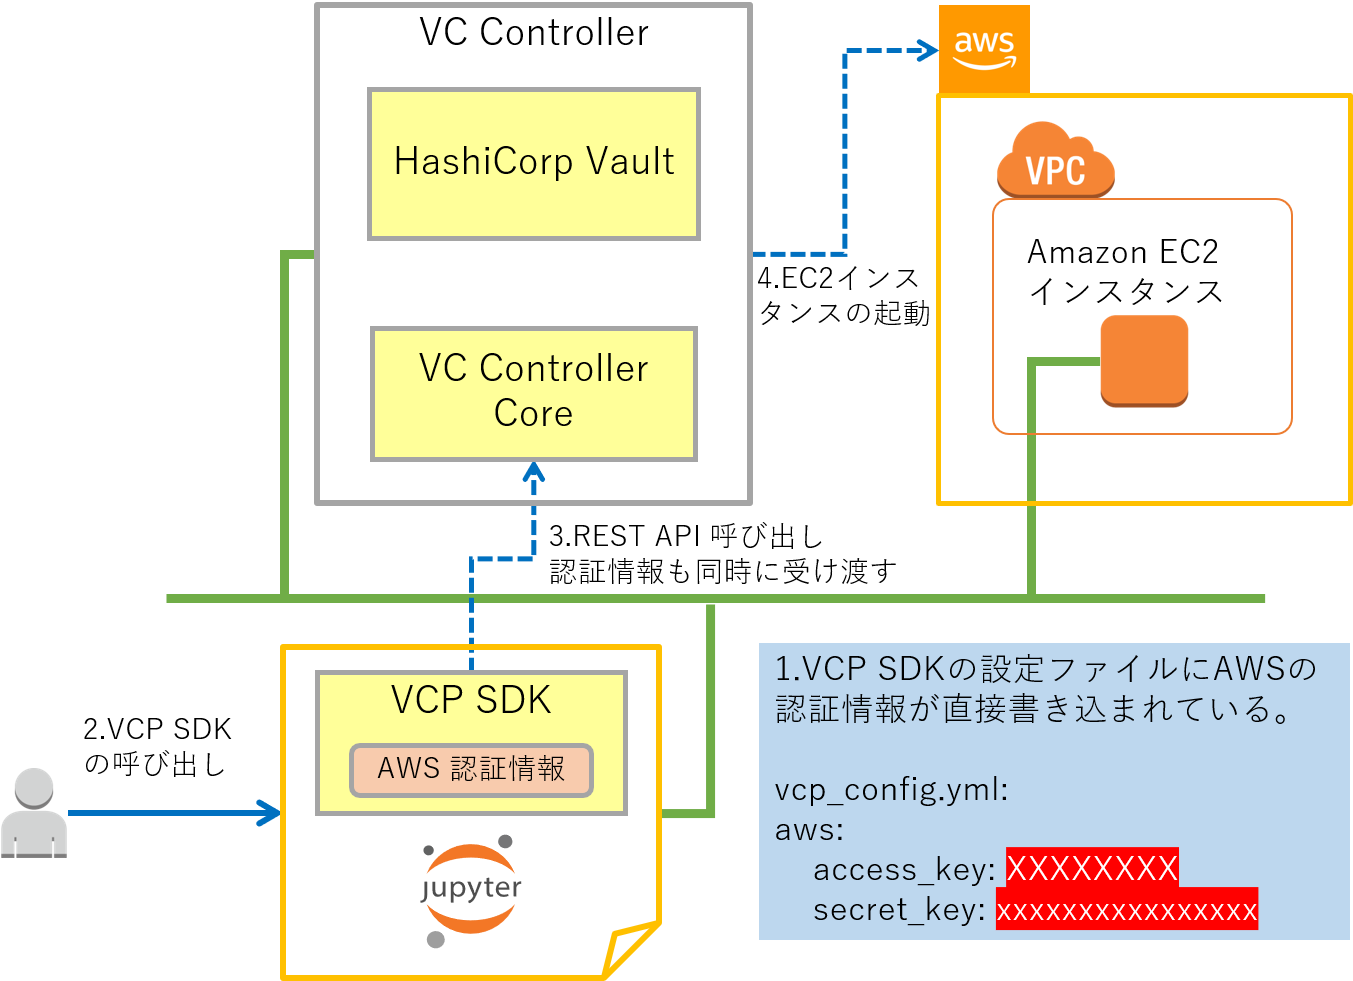

1. AWSの認証情報は、事前にVCP SDKの設定ファイル`vcp_config.yml`に平文で書き込まれています
1. ユーザによってVCP SDKが呼び出されます
1. VCP SDKによってVC Controller Coreに対する REST APIが呼び出されます
  * その際にパラメータとして AWSの認証情報が付加されます
1. VC Controller Coreは受け取った認証情報を用いて AWS APIを実行してAmazon EC2インスタンスを起動します

### Vaultサーバを利用する場合
Vault サーバを利用する場合のクラウドプロバイダの認証情報の扱いを確認します。

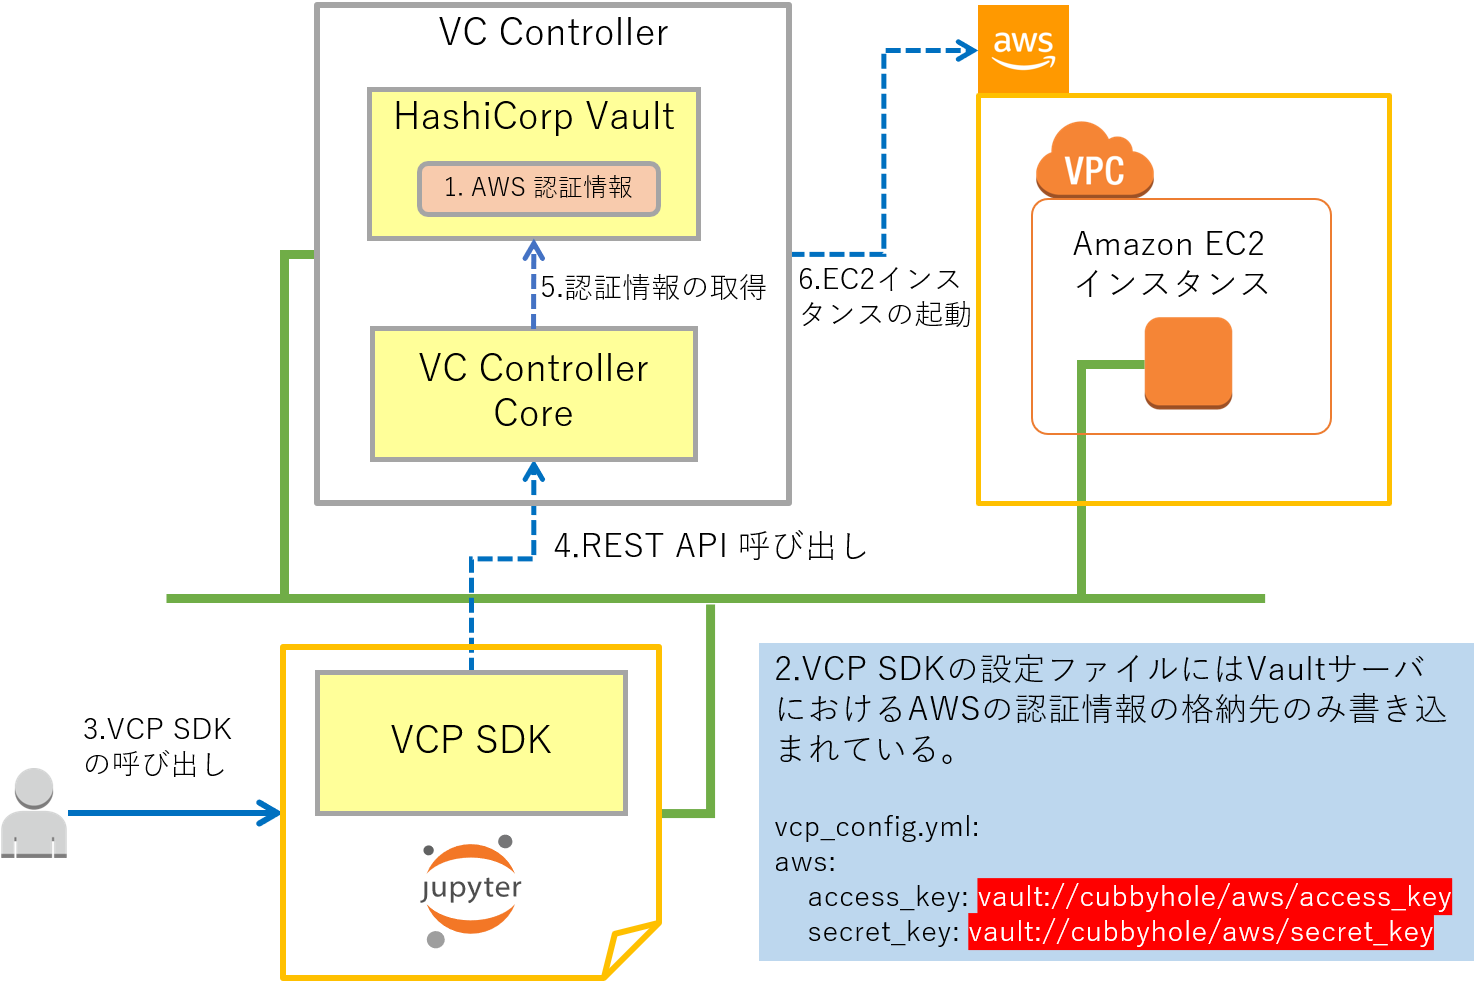

1. AWSの認証情報は、事前にVC ControllerのVaultサーバに格納されています。
  - Vaultサーバの機能によって認証情報は暗号されて格納されています
1. VCP SDKの設定ファイル`vcp_config.yml`にはVaultサーバにおける認証情報の格納場所が記されています
1. ユーザによってVCP SDKが呼び出されます
1. VCP SDKによってVC Controller Coreに対する REST APIが呼び出されます
  - その際VC Controller Coreとの間で認証情報が受け渡されることはなく、Vaultサーバの格納場所のみを渡します
1. VC Controller Coreは受け取ったVaultサーバの格納場所から認証情報を取得します
1. VC Controller Coreは取得した認証情報を用いて AWS APIを実行してAmazon EC2インスタンスを起動します

## 操作手順

このNotebookでの操作手順は以下のようになります。

1. Vault サーバに HTTP API でアクセスして値の読み書きを行う
1. AWSの認証情報をVaultサーバに格納する
1. AWSの認証情報を設定ファイルに直書きせず、Vaultサーバから取得するようにVCP SDKを設定する
1. 新たな設定でVCP SDKでAWSのリソースを作成できることを確認する

# Vaultサーバにアクセスするための準備

Vaultサーバにアクセスするのに必要となるアクセストークンの入力やアドレスの設定を行います。

## アクセストークンの入力

VaultサーバにアクセスするにはVC Controllerのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンを入力してください。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


入力された値が正しいことを確認するために、VCP SDKの初期化を行います。アクセストークンが正しく入力されていない場合は、VCP SDKの初期化がエラーとなり以下のようなメッセージが表示されます。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/09/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK


vcp = VcpSDK(
    vcc_access_token  # VCCのアクセストークン
)

## Vaultサーバのアドレスを確認する

VCP SDKからVaultサーバのアドレスを取得します。取得したアドレスは後でVaultサーバにアクセスする際に利用するので変数`vault_address`に格納しておきます。

In [3]:
# VCP SDKからVaultサーバのアドレスを取得する
vault_address = VcpSDK.vcc_info()['vault_url']

# アドレスを表示する
print(vault_address)

http://10.0.0.1:8200


Vaultサーバのアドレスが正しいことを確認するために Vault サーバの HTTP API を実行してみます。 次のセルを実行してエラーにならなければ、アドレスが正しいことが確認できます。

> ここでは [Helpを取得するHTTP API](https://www.vaultproject.io/api/index.html#help)を実行しています。

In [4]:
!curl -I --fail --header "X-Vault-Token:{vcc_access_token}" \
    "{vault_address}/v1/cubbyhole?help=1"

VaultサーバのHTTP APIについては次節以降で説明します。

## ライブラリの準備

このNotebookでは Vaultサーバ の HTTP API を呼び出すために、Python のライブラリ[Requests](http://docs.python-requests.org/en/master/)を利用します。ここでは Requests が利用できることの確認と簡単な使い方について記します。

まず、この環境から Requests が利用できることを確認します。次のセルを実行してエラーにならないことを確認してください。

In [5]:
import requests

エラーになった場合はライブラリのインストールを行います。次のセルのコメントを外して実行してください。

> ハンズオン環境ではインストール済なので実行する必要はありません。

In [6]:
# !pip install --user requests

Requests を使って試しに https://www.nii.ac.jp/ にアクセスしてみます。

In [7]:
# https://www.nii.ac.jp/ に GET のリクエストを行う
r = requests.get('https://www.nii.ac.jp')
r

<Response [200]>

リクエストが成功したことを示すステータスコード[200](https://developer.mozilla.org/ja/docs/Web/HTTP/Status/200)がレスポンスとして返されます。

取得したテキストを表示してみます。

In [8]:
print(r.text)

<!DOCTYPE html>
<html lang="ja">
<head>
<!-- Google Tag Manager -->
<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src=
'https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);
})(window,document,'script','dataLayer','GTM-PDNSR5');</script>
<!-- End Google Tag Manager -->
	<meta http-equiv="content-type" content="text/html; charset=UTF-8" />
	<meta http-equiv="content-language" content="ja" />
	<title>å½ç«æå ±å­¦ç ç©¶æ / National Institute of Informatics</title>
	<meta name="viewport" content="width=640">
	<meta name="robots" content="index,follow" />
	<meta name="keywords" content="NII,æå ±å­¦,CSI,ãªã¼ãã³ãã¦ã¹,å¸æ°è¬åº§,SINET,CiNii,ãªãã¸ããª,ç§ç è²»ç ç©¶çªå·,ãµã¤ãã¼,è«ææ¤ç´¢" />
	<meta name="description" content="å½ç«æå ±å­¦ç ç©¶æã¯ãæå ±å­¦ã¨ããæ

`GET`以外のメソッド(POST, PUT, DELETE, HEAD, ...)でリクエストを行う場合は以下のように呼び出すことができます。
```
r = requests.post(url)
r = requests.put(url)
r = requests.delete(url)
r = requests.head(url)
```

# Vaultサーバにアクセスする

Vaultサーバに対して[HTTP API](https://www.vaultproject.io/api/index.html)でアクセスして値の格納、取得などの操作を行ってみます。

VaultサーバのHTTP APIはシークレットエンジン毎にそれぞれ用意されています。

1. [KV シークレットエンジン Version 1 API](https://www.vaultproject.io/api/secret/kv/kv-v1.html)
1. [Cubbyhole シークレットエンジン API](https://www.vaultproject.io/api/secret/cubbyhole/index.html)

ここではVCPでの利用機会が多いと思われる Cubbyholeシークレットエンジンの例を紹介します。

## 値を格納する

まずは以下のような設定で値を格納してみます。

* シークレットエンジン
  - cubbyhole
* 格納場所
  - vcp/my-secret
* 格納データ(Key=Value)
  - foo=bar
  - zip=zap

In [9]:
# HTTP APIのURL
url = '{addr}/v1/{engine}/{path}'.format(
    addr=vault_address,
    engine='cubbyhole',    # シークレットエンジンの指定
    path='vcp/my-secret',  # 格納場所の指定
)
print(url)

# 格納データを dictに設定する
payload = {
    'foo': 'bar',
    'zip': 'zap',
}

# アクセストークンをHTTPヘッダに設定する
custom_headers = {
    'X-Vault-Token': vcc_access_token,
}

# 値を格納する HTTP APIを呼び出す
r = requests.post(url, headers=custom_headers, json=payload)
r

http://10.0.0.1:8200/v1/cubbyhole/vcp/my-secret


<Response [204]>

HTTP APIの URL が `http://xxx.xxx.xxx.xxx:8200/v1/cubbyhole/vcp/my-secret` として表示されているはずです。その後に`204`のステータスコードがレスポンスとして表示されていれば `cubbyhole` への値の格納は成功です。

[cubbyholeに値を格納するAPI](https://www.vaultproject.io/api/secret/cubbyhole/index.html#create-update-secret)についてもう少し詳しくみてみます。

> APIの詳細についてはリンク先の公式ドキュメントを参照してください。

まず、Vaultサーバに値を格納する場合の HTTP メソッドですが、`POST`, `PUT` のいずれかを用います。どちらを用いても同じですが、上の例では `POST`を使用しています。

Requestsライブラリで HTTPメソッドの`POST`リクエストを行うには `url`を指定して `post()` を呼び出します。

```
r = requests.post(url, ...)
```

値の格納が成功した場合のレスポンスのステータスコードは `204` になります。

シークレットエンジンと格納場所の指定は `POST`を行う URLで設定します。URLを以下のように指定します。

```
{vaultサーバのアドレス}/v1/{シークレットエンジン}/{格納場所}
```

例えば、先程の例のように `cubbyhole` の `vcp/my-secret` に格納する場合は

```
http://xxx.xxx.xxx.xxx:8200/v1/cubbyhole/vcp/my-secret
```

のようになります。格納場所の指定には `vcp/my-secret`のようにパスライクな値を指定することができます。

次にVaultサーバに格納するデータの指定方法ですが、HTTPの本文（メッセージボディー）に json 形式でキー、バリューを記述します。キー、バリューの組は複数の組を記述することができます。

Requests ライブラリで`POST`リクエストの本文をjson形式で指定するには `post()` の `json`パラメータにキー、バリューの `dict` を設定します。

```
requests.post(..., json={
    'key1': 'value1',
    'key2': 'value2',
})
```

最後にVaultサーバのHTTP APIにアクセスするためのアクセストークンの指定方法について記します。アクセストークンはHTTPリクエストの `X-Vault-Token` ヘッダーに指定します。

Requests ライブラリでHTTPリクエストにカスタムヘッダーを指定するには、`post()` の `headers`パラメータにヘッダーの `dict` を設定します。

```
requests.post(..., headers={'X-Vault-Token': 'xxxxxxxxxx'})
```

## 値を取得する

先程Vaultサーバに格納した値を取得してみます。

値を格納する場合の HTTPメソッドは `POST`, `PUT`でしたが、[値を取得するAPI](https://www.vaultproject.io/api/secret/cubbyhole/index.html#read-secret)では `GET` を用います。また成功した場合のステータスコードは `200` になります。

URLとヘッダーの指定方法は、値を格納するHTTP APIの場合に記したものと同様です。

In [10]:
# URLは先ほどと同じなので設定済みの値をそのまま利用している
# アクセストークンを設定設定したヘッダーについても同様

# URLを表示する
print(url)

# 値を取得する HTTP APIを呼び出す
r = requests.get(url, headers=custom_headers)
r

http://10.0.0.1:8200/v1/cubbyhole/vcp/my-secret


<Response [200]>

取得した値はHTTPレスポンスの本文に json 形式で格納されています。

Requestsライブラリではレスポンスの本文から json 形式のデータを取り出すための関数 `json()`が用意されています。`json()`を呼び出してVaultサーバからのレスポンスを取得してみます。

In [11]:
r.json()

{'auth': None,
 'data': {'foo': 'bar', 'zip': 'zap'},
 'lease_duration': 0,
 'lease_id': '',
 'renewable': False,
 'request_id': '054155cb-814e-c8b7-fb7d-20b962b7c4f8',
 'warnings': None,
 'wrap_info': None}

レスポンスの本文にはキー、バリューの値だけではなくそれに付随するメタデータも含まれています。キー、バリューは `data` に対応する部分なので、そこだけを表示させてみます。

In [12]:
r.json()['data']

{'foo': 'bar', 'zip': 'zap'}

先程設定したキー、バリューが取得できることが確認できました。

## 一覧取得

Vaultサーバの指定した場所に格納されているエントリの一覧を取得してみます。

[エントリの一覧を取得する](https://www.vaultproject.io/api/secret/cubbyhole/index.html#list-secrets)にはHTTPのメソッドに `LIST` を指定します。このメソッドは HTTP の標準メソッドではないので Requests ライブラリで呼び出すには `request()`関数を利用します。

```
r = requests.request('LIST', ...)
```

指定する URL にはエントリの一覧を取得するパスを指定します。先程の実行例では `vcp/` を指定しています。

> 格納場所の指定には、値を格納したパスではなく、親ディレクトリに相当するパスを指定する必要があります。

In [13]:
# HTTP APIのURL
url_p = '{addr}/v1/{engine}/{path}'.format(
    addr=vault_address,
    engine='cubbyhole',   # シークレットエンジンの指定
    path='vcp/',          # 一覧取得対象の指定
)
# URLを表示する
print(url_p)

# エントリの一覧を取得する HTTP APIを呼び出す
# アクセストークンは先ほどと同じなので設定済みの値をそのまま利用している
r = requests.request('LIST', url_p, headers=custom_headers)
r

http://10.0.0.1:8200/v1/cubbyhole/vcp/


<Response [200]>

一覧の取得に成功したするとレスポンスのステータスコードは `200`になります。

取得結果はレスポンスの本文に json 形式で格納されています。そのうち、エントリの一覧情報は `data` 要素にあります。

In [14]:
r.json()['data']

{'keys': ['my-secret']}

URLに親ディレクトリ相当のパスではなく、値が格納されているパスを指定するとエラー`404`になります。

In [15]:
# URLを表示する
print(url)

r = requests.request('LIST', url, headers=custom_headers)
print(r)

http://10.0.0.1:8200/v1/cubbyhole/vcp/my-secret
<Response [404]>


## 値の削除

先程格納した値を削除してみます。

[削除するには](https://www.vaultproject.io/api/secret/cubbyhole/index.html#delete-secret) `DELETE`メソッドを用います。URLとヘッダーの指定は値の設定、取得の場合と同様です。

In [16]:
# URLは先ほどと同じなので設定済みの値をそのまま利用している
# アクセストークンを設定設定したヘッダーについても同様

# URLを表示する
print(url)

# 値を削除する HTTP APIを呼び出す
r = requests.delete(url, headers=custom_headers)
r

http://10.0.0.1:8200/v1/cubbyhole/vcp/my-secret


<Response [204]>

削除に成功した場合のステータスコードは `204`です。

削除できたことを確認するために格納されているエントリの一覧取得を行ってみます。
`vcp/`に格納したエントリが全て無くなっているので `404` がレスポンスとして返ってくるはずです。

In [17]:
# URLを表示する
print(url_p)

# 一覧取得
r = requests.request('LIST', url_p, headers=custom_headers)
print(r)

http://10.0.0.1:8200/v1/cubbyhole/vcp/
<Response [404]>


# AWSの認証情報を Vaultサーバから読み込むようにVCP SDKの設定を変更する

現在のハンズオン環境では VCP SDKの設定ファイル`vcp_config.yml`にAWSの認証情報が直接書き込まれています。これをVaultサーバから AWSの認証情報を読み込むように設定を変更します。

## AWS の認証情報を Vault サーバに格納する

VCP SDKの設定ファイルに書き込まれているAWSの認証情報をVaultサーバに格納します。

ハンズオン環境ではVCP SDKの設定ファイル`vcp_config.yml`にAWSの認証情報が平文で書き込まれています。次のセルを実行すると`vcp_config.yml`をJupyter Notebook のファイル編集機能で開くためのリンクが表示されます。`vcp_config.yml`を開いて認証情報を確認してください。

ここで必要となるAWSのアクセスキー、シークレットキーは`vcp_config.yml`に`access_key`, `secret_key` として書き込まれています。。

```
# AWS の設定
#
aws:
  access_key: XXXXXXXX
  secret_key: xxxxxxxxxxxx
```

In [18]:
%run scripts/nbutils.py

nb_html_link('/notebooks/notebook/vcpsdk/config/vcp_config.yml', 'vcp_config.yml')

AWSのアクセスキー、シークレットキーをVaultサーバに格納するために、まずはPythonの変数にそれぞれの値を設定します。

`vcp_config.yml`で確認したAWSのアクセスキーの値を入力してください。

In [19]:
import getpass
aws_access_key = getpass.getpass() 

········


同様にAWSのシークレットキーの値を入力してください。

In [20]:
aws_secret_key = getpass.getpass()

········


VaultのHTTP APIを呼び出し、AWSのアクセスキーとシークレットキーを Vaultサーバに格納します。格納場所はそれぞれ以下のようにします。

* アクセスキー
  - cubbyhole/aws/access_key
* シークレットキー
  - cubbyhole/aws/secret_key

まずアクセスキーをVaultサーバに格納します。

In [21]:
# 格納データを dictに設定する
# VC Controller のフォーマットに合わせるためにキーの名前は value にする
payload = {
    'value': aws_access_key,
}

# HTTP APIのURL
url = '{addr}/v1/{engine}/{path}'.format(
    addr=vault_address,
    engine='cubbyhole',
    path='aws/access_key',
)
print(url)

# 値の格納
# アクセストークンは先ほどと同じなので設定済みの値をそのまま利用している
r = requests.post(url, headers=custom_headers, json=payload)
r

http://10.0.0.1:8200/v1/cubbyhole/aws/access_key


<Response [204]>

値の格納が成功したこと（レスポンスが `204`であること）を確認します。

次にシークレットキーも同様に値の格納を行います。

In [22]:
# 格納データを dictに設定する
# VC Controller のフォーマットに合わせるためにキーの名前は value にする
payload = {
    'value': aws_secret_key,
}

# HTTP APIのURL
url = '{addr}/v1/{engine}/{path}'.format(
    addr=vault_address,
    engine='cubbyhole',
    path='aws/secret_key',
)
print(url)

# 値の格納
# アクセストークンは先ほどと同じなので設定済みの値をそのまま利用している
r = requests.post(url, headers=custom_headers, json=payload)
r

http://10.0.0.1:8200/v1/cubbyhole/aws/secret_key


<Response [204]>

値の格納が成功したこと（レスポンスが `204`であること）を確認します。

Vaultサーバに格納されたエントリの一覧を取得して、それぞれの値が所定の場所に格納されていることを確認します。

In [23]:
# HTTP APIのURL
url_p = '{addr}/v1/{engine}/{path}'.format(
    addr=vault_address,
    engine='cubbyhole',
    path='aws/',
)
print(url_p)

# 一覧の取得
r = requests.request('LIST', url_p, headers=custom_headers)
print(r)

# 取得した一覧の表示
print(r.json()['data'])

http://10.0.0.1:8200/v1/cubbyhole/aws/
<Response [200]>
{'keys': ['access_key', 'secret_key']}


## 認証情報をVaultサーバから取得するように設定する

認証情報をVaultサーバから取得するようにVCP SDKの設定ファイル`vcp_config.yml`を変更します。

`vcp_config.yml`では、実際の値がVaultサーバに格納されていることを示すために以下のような記法が利用できます。

```
vault://(シークレットエンジン)/(格納場所のパス)
```

先程AWSのアクセスキーを Vault サーバ cubbyholeシークレットエンジン の `aws/access_key` に格納しましたが、この格納場所は

```
vault://cubbyhole/aws/access_key
```

と記すことができます。


では、実際に `vcp_config.yml`の設定を変更する作業を行ってみます。

まず、元の設定ファイルを一時的に退避する作業ディレクトリを作成します。

In [24]:
import tempfile

work_dir = tempfile.mkdtemp()
print(work_dir)

/tmp/tmpj9bo5qz0


現在のVCP SDKの設定ファイル`vcp_config.yml`を作業ディレクトリにコピーします。

In [25]:
!cp /notebooks/notebook/vcpsdk/config/vcp_config.yml {work_dir}

次のセルを実行すると表示されるリンクをから `vcp_config.yml` が編集できます。AWSに対応する設定を以下のように変更してください。

```
aws:
  access_key: vault://cubbyhole/aws/access_key
  secret_key: vault://cubbyhole/aws/secret_key
```

> 設定ファイルは YAML フォーマットなので空白やインデントの扱いに注意してください。

In [26]:
%run scripts/nbutils.py

nb_html_link('/notebooks/notebook/vcpsdk/config/vcp_config.yml', 'vcp_config.yml')

設定ファイルが正しいフォーマットで保存されたことを確認するために VCP SDKで設定ファイルを読み込んでみます。フォーマットに誤りがある場合は次のセルを実行するとエラーになりますので、先程のリンクから再度編集しなおしてください。

In [27]:
from vcpsdk.vcpsdk import VcpConfigYaml

# VCP SDK の設定ファイルを読み込む
config = VcpConfigYaml().load_config('vcp_config')

元のファイルを復元してから編集しなおしたい場合は次のセルのコメント `#` を外して実行してください。

> 編集済のファイルを上書きしてしまいますので、注意して操作してください。

In [ ]:
#!cp {work_dir}/vcp_config.yml /notebooks/notebook/vcpsdk/config/

ここまでの作業でVCP SDKの設定ファイル`vcp_config.yml`を認証情報が直接記載されないように変更できました。

## VCノード(Amazon EC2インスタンス)を起動できることを確認する

設定変更が正しくおこなわれたことを確認するためにVCノード(Amazon EC2インスタンス)をVCP SDKで起動してみます。

### VCノードを起動する

UnitGroupを作成します。

> `vcp` はアクセストークンの値をチェックしたときに作成したものを利用しています。

In [28]:
unit_group = vcp.create_ugroup(
    'handson102'       # UnitGroupの名前
)

UnitGroup, Unit, Nodeの状態を確認しておきます。

In [29]:
from IPython.display import display

# UnitGroupの一覧を DataFrame で表示する
display(vcp.df_ugroups())

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vcno,vctype,vcname,state,vcid,cdate
0,37,compute,handson102,RUNNING,011f0fa1...,2018/09/28 06:13:27 UTC


,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

sshでログインするための秘密鍵のパスを設定します。

In [30]:
import os
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

spec を設定します。

In [31]:
# specの取得
spec = VcpSDK.get_spec('aws', 'small')

# SSHの鍵ファイルをVCノードの設定パラメータに合わせたフォーマットに変換して spec に設定する
out = !ssh-keygen -y -f {ssh_private_key} | base64 -w 0
b64_ssh_public_key = out[0]
spec.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

# 設定内容の表示
print(spec)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


Unitの作成とVCノードの起動を行います。

> VCノードの起動には1分半～２分程度かかります。

In [32]:
unit = unit_group.create_unit('aws-server', spec)

2018-09-28 15:14:49,499 - INFO - BOOTING ... 0 sec
2018-09-28 15:14:54,709 - INFO - BOOTING ... 5 sec
2018-09-28 15:14:59,909 - INFO - BOOTING ... 10 sec
2018-09-28 15:15:05,118 - INFO - BOOTING ... 15 sec
2018-09-28 15:15:10,326 - INFO - BOOTING ... 20 sec
2018-09-28 15:15:15,527 - INFO - BOOTING ... 25 sec
2018-09-28 15:15:20,742 - INFO - BOOTING ... 30 sec
2018-09-28 15:15:25,941 - INFO - BOOTING ... 35 sec
2018-09-28 15:15:31,154 - INFO - BOOTING ... 40 sec
2018-09-28 15:15:36,356 - INFO - BOOTING ... 45 sec
2018-09-28 15:15:41,558 - INFO - BOOTING ... 50 sec
2018-09-28 15:15:46,787 - INFO - BOOTING ... 55 sec
2018-09-28 15:15:51,993 - INFO - BOOTING ... 60 sec
2018-09-28 15:15:57,213 - INFO - BOOTING ... 65 sec
2018-09-28 15:16:02,434 - INFO - BOOTING ... 70 sec
2018-09-28 15:16:07,651 - INFO - BOOTING ... 75 sec
2018-09-28 15:16:12,855 - INFO - unit aws-server is RUNNING


設定変更が正しくおこなわれていた場合 VCノードの起動に成功します。

Vaultサーバに格納した認証情報に誤りがありVCノードの起動に失敗した場合は以下のようなメッセージが表示されます。

```
2018-09-XX XX:XX:XX,XXX - INFO - unit aws-server is ERROR
2018-09-XX XX:XX:XX,XXX - ERROR - [Vc]
+ type[compute] name[handson102] vcno(000) state[ERROR] vcid[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx]

[VcUnit]
+ type[compute] name[aws-server]  state[ERROR]
*** HAS ERROR:
---
2018/09/XX XX:XX:XX UTC: * provider.aws: version = "~> 1.29"
2018/09/XX XX:XX:XX UTC: * provider.aws: InvalidClientTokenId: The security token included in the request is invalid.
```

この場合は、次のセルのコメントを外してVCの削除を行って、
[AWS の認証情報を Vault サーバに格納する](#AWS-の認証情報を-Vault-サーバに格納する)の手順から再度実行してください。

In [33]:
# unit_group.cleanup()

設定ファイル`vcp_config.yml`の記述に誤りがありVCノードの起動に失敗した場合は以下のようなメッセージが表示されます。

```
2018-09-XX XX:XX:XX,XXX - ERROR - add unit failed: http_status(403)
NoneType
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/09/XX XX:XX:XX UTC: VCPVaultReadException: xxxxxxxx-x:cubbyhole/XXX/XXX vault read is failed: ROR - 2018/09/XX XX:XX:XX UTC: VCPVaultReadException: xxxxxxxx-x:cubbyhole/XXX/XXX vault read is failed:
```

この場合は、次のセルのコメントを外して設定ファイル`vcp_config.yml`の復元と VCの削除を行って、
[認証情報をVaultサーバから取得するように設定する](#認証情報をVaultサーバから取得するように設定する)の手順から再度実行してください。

In [34]:
#!cp {work_dir}/vcp_config.yml /notebooks/notebook/vcpsdk/config/ 
# unit_group.cleanup()

VCノードの起動に成功した場合は、Unit, VCノードの一覧を表示させてみます。

In [35]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,37,handson102,RUNNING,011f0fa1...,2018/09/28 06:13:27 UTC,aws-server,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,37,handson102,aws-server,RUNNING,1,12def2bf...,RUNNING,172.30.2.162,i-07ce311f3da54a3f0,VCP-020661f0-011f0fa1,none


### ssh でログインして操作する

起動したVCノードに対して `uname -a`, `dh -h`, `free` などのコマンドを実行してみます。

In [36]:
# VCノードのIPアドレスの取得
ip_address = unit_group.find_ip_addresses()[0]
print(ip_address)

# sshに指定するオプションの設定
ssh_opts = "-i {} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q".format(ssh_private_key)

print('-' * 40)

# uname -a の実行
!ssh {ssh_opts} root@{ip_address} uname -a

print('-' * 40)

# df -h の実行
!ssh {ssh_opts} root@{ip_address} df -h

print('-' * 40)

# free の実行
!ssh {ssh_opts} root@{ip_address} free

172.30.2.162
----------------------------------------
Linux ip-172-30-2-162 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux
----------------------------------------
Filesystem                Size      Used Available Use% Mounted on
none                     19.6G      1.8G     16.8G  10% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/resolv.conf
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hostname
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /var/lib/docker
none                      3.9G         0      3.9G   0% /tmp
/dev/xvda1               19.6G      1.8G     16.8G  10% /var/lib/docker/aufs
---

VCP SDKの設定ファイルに直接AWSの認証情報を書き込むことをせずにVCノードが起動できることを確認できました。

### 後始末

起動したVCノードを全て削除します。

In [37]:
unit_group.cleanup()

2018-09-28 15:16:34,787 - INFO - aws-server is DELETING ... 0 sec
2018-09-28 15:16:40,059 - INFO - aws-server is DELETING ... 5 sec
2018-09-28 15:16:45,316 - INFO - aws-server is DELETING ... 10 sec
2018-09-28 15:16:50,566 - INFO - aws-server is DELETING ... 15 sec
2018-09-28 15:16:55,827 - INFO - aws-server is DELETING ... 20 sec
2018-09-28 15:17:01,073 - INFO - aws-server is DELETING ... 25 sec
2018-09-28 15:17:06,328 - INFO - aws-server is DELETING ... 30 sec
2018-09-28 15:17:11,584 - INFO - aws-server is DELETING ... 35 sec
2018-09-28 15:17:16,836 - INFO - aws-server is DELETING ... 40 sec
2018-09-28 15:17:22,085 - INFO - aws-server is DELETING ... 45 sec
2018-09-28 15:17:27,298 - INFO - cleanup completed. vc handson102 is cleanup(no unit)


編集前の設定ファイル`vcp_config.yml`を退避してある作業ディレクトリを削除します。

In [38]:
!rm -rf {work_dir}